# ResNet 18

***
## IMPORTS

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
import torchmetrics
import os
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import cv2 
import pandas as pd 

***
## FOLDER ESTRUCTURATION

In [5]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [6]:
root_path = "D:/FractureUltrasoundSimulator/FractureUltrasoundSimulator/Resources/Data/Dataset_Fantoma"
save_path = "D:/FractureUltrasoundSimulator/FractureUltrasoundSimulator/Resources/Data/Dataset_Fantoma/Processed"
sums, sums_squared = 0, 0
cat = ["Healthy", "Fracture"]
a = 0
if not os.path.exists(save_path + "/" + "train"):
    for c, patient_status in enumerate(tqdm(cat)):
    
        path = root_path + "/" + patient_status
        i = len(os.listdir(path))

        for x in range(i):
        
            path = root_path + "/" + patient_status + "/" + patient_status + str(x) + ".png"
        
            img = Image.open(path)
            img_np = np.asarray(img)/255
            img_array = cv2.resize(img_np, (224, 224)).astype(np.float16) 
            
            label = 0 if patient_status == "Healthy" else 1
            train_or_val = "train" if x <=47 else "val"
        
            current_save_path = save_path + "/" + train_or_val 
            if not os.path.exists(current_save_path):
                os.mkdir(os.path.join(save_path, train_or_val))
        
            current_save_path = save_path + "/" + train_or_val + "/" + str(label)
            if not os.path.exists(current_save_path):
                current = save_path + "/" + train_or_val
                os.mkdir(os.path.join(current, str(label)))
    
            current_save_path = current_save_path + "/" + patient_status + str(x)
            np.save(current_save_path, img_array)
    
            normalizer = 224*224
            if train_or_val == "train":
                scale_factor = 100
                img_array_scaled = img_array / scale_factor
                sums += np.sum(img_array_scaled) / normalizer
                sums_squared += (img_array_scaled**2).sum() / normalizer

In [7]:
mean = sums / 140
std = np.sqrt(sums_squared / 140 - (mean**2))
mean = mean*100
std = std*100
print(f"Mean of Dataset: {mean}, STD: {std}")

Mean of Dataset: 0.0, STD: 0.0


***
## DATASET AND DATALOADER CREATION

In [8]:
train_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(0.12967301527195704, 0.11952487479741893),
                                transforms.RandomHorizontalFlip(), #Volteo horizontal, reflejo espejo
                                transforms.RandomRotation(15)
]) #list of multiple transforms

val_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(0.12967301527195704, 0.11952487479741893)
])

In [10]:
train_dataset = torchvision.datasets.DatasetFolder("D:/FractureUltrasoundSimulator/FractureUltrasoundSimulator/Resources/Data/Dataset_Fantoma/Processed/train", 
                                                   loader=load_file, extensions="npy", transform=train_transforms)
val_dataset = torchvision.datasets.DatasetFolder("D:/FractureUltrasoundSimulator/FractureUltrasoundSimulator/Resources/Data/Dataset_Fantoma/Processed/val", 
                                                   loader=load_file, extensions="npy", transform=val_transforms)

In [11]:
batch_size=10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True )
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False )

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 96 train images and 32 val images


***
## TRAINING PREPARATION

In [12]:
class FractureModel(pl.LightningModule):
    def __init__(self, weight=1):
        super().__init__()
        
        self.model = torchvision.models.resnet18()
        # Se cambia conv1 de 3 a 1 canal de input.
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # Se cambia out_feature de el fully connected layer (fc en resnet18) de 1000 a 1.
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.loss = torch.nn.BCEWithLogitsLoss(torch.tensor([weight]))
        self.val_acc = torchmetrics.Accuracy("binary")

    def forward(self, data):
        pred = self.model(data) 
        return pred # El modelo devuelve la predicción.
    
    def training_step(self, batch, batch_idx):
        us_image, label = batch
        label = label.float()  # Convierte la estiqueta en float (para obetener la loss function).
        pred = self(us_image)[:,0]  
        loss = self.loss(pred, label)  # Se obtiene la pérdida "loss".
        acc = self.val_acc(torch.sigmoid(pred), label.int())
        # Se hace un log de el loss y la acertividad.
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        return loss
        
    def validation_step(self, batch, batch_idx):
        # Los mismos pasos seguidos que en el training_step.
        us_image, label = batch
        label = label.float()
        pred = self(us_image)[:,0] 
        loss = self.loss(pred, label)
        acc = self.val_acc(torch.sigmoid(pred), label.int())
        # Se hace un log de el loss y la acertividad.
        self.log('val_loss', loss)
        self.log('val_acc', acc)
        
    def configure_optimizers(self):
        return [self.optimizer]

In [13]:
model = FractureModel()

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device);

In [11]:
checkpoint = ModelCheckpoint(
    monitor='val_acc',
    mode='max',
    filename='best_model_{epoch:02d}',
    save_top_k=1,
    save_weights_only=True) 

In [12]:
# Creación del trainer
trainer = pl.Trainer("cuda", logger=CSVLogger(save_dir="./logs"), log_every_n_steps=1,
                     callbacks= [checkpoint],
                     precision=16,
                     max_epochs=120)


D:\anaconda3\lib\site-packages\lightning_fabric\connector.py:562: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [13]:
trainer.fit(model, train_loader, val_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | model   | ResNet            | 11.2 M
1 | loss    | BCEWithLogitsLoss | 0     
2 | val_acc | BinaryAccuracy    | 0     
----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

D:\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
D:\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=120` reached.


***
## PARAMETERS VISUALIZATION

In [16]:
model = FractureModel.load_from_checkpoint("D:/UltrasoundAI/UltrasoundAI/FractureClassification/Resources/Model/BEST ResNet18/checkpoints/best_model_epoch=109.ckpt")
model.eval()
model.to(device);

D:\ANACONDA\lib\site-packages\pytorch_lightning\utilities\migration\utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.0.2, which is newer than your current Lightning version: v2.0.0
  rank_zero_warn(


In [17]:
preds = []
labels = []

with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

  0%|          | 0/32 [00:00<?, ?it/s]

In [18]:
preds

tensor([0.2872, 0.4508, 0.4020, 0.6379, 0.0803, 0.0936, 0.2183, 0.1897, 0.3503,
        0.0769, 0.0616, 0.0657, 0.1303, 0.3205, 0.0726, 0.0755, 0.9573, 0.9877,
        0.5698, 0.1652, 0.9990, 0.9549, 0.9965, 0.9972, 0.9720, 0.9580, 0.6585,
        0.9767, 0.9999, 0.9736, 0.9455, 0.9992])

In [19]:
labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.int32)

In [20]:
acc = torchmetrics.Accuracy("binary")(preds, labels)
precision = torchmetrics.Precision("binary")(preds, labels)
recall = torchmetrics.Recall("binary")(preds, labels)
cm = torchmetrics.ConfusionMatrix(task="binary", num_classes=2)(preds, labels)

print(f"Val Accuracy: {acc}")
print(f"Val Precision: {precision}")
print(f"Val Recall: {recall}")
print(f"Confusion Matrix:\n {cm}")

Val Accuracy: 0.9375
Val Precision: 0.9375
Val Recall: 0.9375
Confusion Matrix:
 tensor([[15,  1],
        [ 1, 15]])


Intervalo de confianza del 95% para AUC-ROC: (0.5333579250639724, 1.3963295749360276)
Área bajo la curva ROC (AUC-ROC): 0.96484375


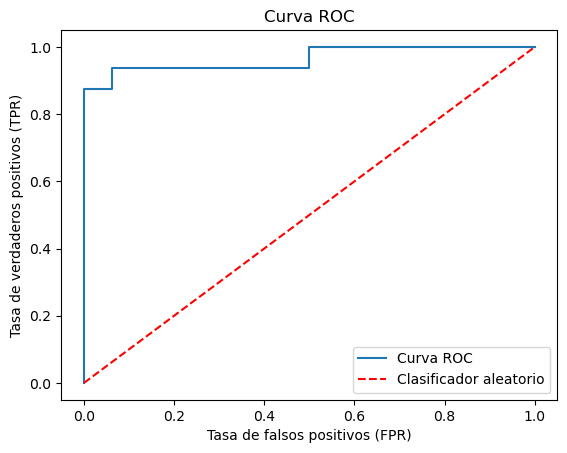

In [21]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from scipy.stats import norm
fpr, tpr, thresholds = roc_curve(labels, preds)
plt.plot(fpr, tpr, label='Curva ROC')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Clasificador aleatorio')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curva ROC')
plt.legend()

auc_score = roc_auc_score(labels, preds)
variance_delong = (auc_score * (1 - auc_score) + (auc_score ** 2) / (2 * len(labels)))
z_score = norm.ppf(0.975) 
ci_lower = auc_score - z_score * np.sqrt(variance_delong)
ci_upper = auc_score + z_score * np.sqrt(variance_delong)

print("Intervalo de confianza del 95% para AUC-ROC:", (ci_lower, ci_upper))
print("Área bajo la curva ROC (AUC-ROC):", auc_score)

plt.show()

In [19]:
def plot_logs(df):
    fig = plt.figure(figsize=(8, 3))
    ax = fig.add_subplot(121)
    df.plot(x='epoch', y=['train_loss'], grid=True, title='Loss', ax=ax)
    ax = fig.add_subplot(122)
    df.plot(x='epoch', y=['train_acc'], grid=True, title='Accuracy', ax=ax)
    plt.tight_layout()
    plt.show()

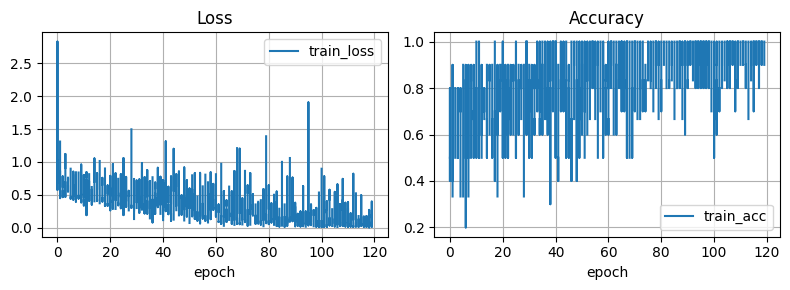

In [20]:
plot_logs(pd.read_csv('D:/UltrasoundAI/UltrasoundAI/FractureClassification/Training/logs/lightning_logs/version_0/metrics.csv'))

***
## SAVING THE MODEL STATE

In [21]:
mod = FractureModel.load_from_checkpoint("D:/UltrasoundAI/UltrasoundAI/FractureClassification/Training/logs/lightning_logs/version_0/checkpoints/best_model_epoch=109.ckpt")

In [22]:
ruta_guardado = 'D:/UltrasoundAI/UltrasoundAI/FractureClassification/Training/logs/lightning_logs/version_0/checkpoints/best_model_epoch=109.pth'
torch.save({'state_dict': mod.state_dict()}, ruta_guardado)